In [1]:
# verify p-onset pickingg

import string
import argparse as ap
import sys
import os
import numpy as np

import obspy
import obspy.core as oc
from obspy import read_inventory

# from datetime import datetime, timedelta
import time

import pylab as plt
import pandas as pd
import h5py


import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import datetime
import warnings

mpl.rcParams['pdf.fonttype'] = 42

warnings.filterwarnings("ignore")

In [2]:
# directory PATH
METADIR = './ingv_metadata'
HDFDIR = './ingv_data'
FIGDIR='./ingv_output'

# file NAMES
# MetaData
events_metaname=os.path.join(METADIR, 'metadata_Instance_events_v2.csv')
# HDF5
gm_hdfname=os.path.join(HDFDIR, 'Instance_events_gm.hdf5')

In [3]:
# read metadata for events and nois
events_metaData = pd.read_csv(
    events_metaname, keep_default_na=False,
    dtype={
        'station_location_code': object, 'source_mt_eval_mode': object,
        'source_mt_status': object,'source_mechanism_strike_dip_rake': object,
        'source_mechanism_moment_tensor': object, 'trace_p_arrival_time': object,
        'trace_s_arrival_time': object
    },
    low_memory=False)

In [4]:
# read waveform
gm_h5File = h5py.File(gm_hdfname, 'r')

In [5]:
from ingv_plot_waveform import split, build_stream, multiple_streams, multiple_streams_zoom

In [6]:
# figure labels
fignumbers = 'abcdefghijklmnopqrstuvwxyz'
alllabs = split(fignumbers)

In [7]:
events_metaData.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159249 entries, 0 to 1159248
Data columns (total 115 columns):
 #    Column                            Non-Null Count    Dtype  
---   ------                            --------------    -----  
 0    source_id                         1159249 non-null  int64  
 1    station_network_code              1159249 non-null  object 
 2    station_code                      1159249 non-null  object 
 3    station_location_code             1159249 non-null  object 
 4    station_channels                  1159249 non-null  object 
 5    station_latitude_deg              1159249 non-null  float64
 6    station_longitude_deg             1159249 non-null  float64
 7    station_elevation_m               1159249 non-null  float64
 8    station_vs_30_mps                 1159249 non-null  float64
 9    station_vs_30_detail              1159249 non-null  object 
 10   source_origin_time                1159249 non-null  object 
 11   source_latitude_deg   

In [8]:
events_metaData.head()

,source_id,station_network_code,station_code,station_location_code,station_channels,station_latitude_deg,station_longitude_deg,station_elevation_m,station_vs_30_mps,station_vs_30_detail,...,trace_sa10_cmps2,trace_sa30_cmps2,trace_name,trace_GPD_P_number,trace_GPD_S_number,trace_EQT_number_detections,trace_EQT_P_number,trace_EQT_S_number,trace_deconvolved_units,source_type
0,10000541,MN,AQU,,HH,42.35400,13.40500,710.0,485.0,Vs30 extracted from ShakeMap,...,7.13432e-05,1.91573e-05,10000541.MN.AQU..HH,1.0,1.0,1.0,1.0,1.0,mps,earthquake
1,10000541,MN,AQU,,HL,42.35400,13.40500,710.0,485.0,Vs30 extracted from ShakeMap,...,0.0001351228,4.95397e-05,10000541.MN.AQU..HL,,,,,,mps2,earthquake
2,10000541,IV,ARRO,,EH,42.57917,12.76567,253.0,549.0,Vs30 extracted from ShakeMap,...,4.59196e-05,2.21168e-05,10000541.IV.ARRO..EH,2.0,1.0,1.0,1.0,1.0,mps,earthquake
3,10000541,IV,ASSB,,HH,43.04260,12.65870,734.0,412.0,Vs30 extracted from ShakeMap,...,6.82975e-05,1.47641e-05,10000541.IV.ASSB..HH,1.0,7.0,1.0,1.0,1.0,mps,earthquake
4,10000541,IV,ATCC,,EH,43.18514,12.63994,557.0,667.0,Vs30 extracted from ShakeMap,...,5.7025e-05,2.82292e-05,10000541.IV.ATCC..EH,1.0,3.0,1.0,1.0,1.0,mps,earthquake


In [9]:
list_eve=['trace_E_min_counts','trace_N_min_counts','trace_Z_min_counts',
         'trace_E_max_counts','trace_N_max_counts','trace_Z_max_counts',
         'trace_E_median_counts','trace_N_median_counts','trace_Z_median_counts',
         'trace_E_mean_counts','trace_N_mean_counts','trace_Z_mean_counts',
         'trace_E_pga_perc','trace_N_pga_perc','trace_Z_pga_perc',
         'trace_E_pga_cmps2','trace_N_pga_cmps2','trace_Z_pga_cmps2',
         'trace_E_pgv_cmps','trace_N_pgv_cmps','trace_Z_pgv_cmps',
         'trace_E_snr_db','trace_N_snr_db','trace_Z_snr_db',
         'trace_E_sa03_cmps2','trace_N_sa03_cmps2','trace_Z_sa03_cmps2',
         'trace_pgv_cmps', 'trace_pga_perc',
         'trace_EQT_number_detections','trace_EQT_P_number','trace_EQT_S_number','trace_GPD_P_number','trace_GPD_S_number']

for ele in list_eve:
    events_metaData[ele] =  pd.to_numeric(events_metaData[ele], errors='coerce')

In [10]:
TOTAL = events_metaData.shape[0]
TOTAL

1159249

In [11]:
# SELECT STRONG MOTION CHANNELS
cha = 'HN'
df_tmp = events_metaData[(events_metaData.source_magnitude >= 3) &
                         (events_metaData['station_channels'] == cha) &
                         (events_metaData.path_ep_distance_km <= 50)]

TOTAL = df_tmp.shape[0]
TOTAL

14996

In [12]:
# NEAR SOURCE PLOT
chosen_lines = []
plots_line = 3

df_tmp = events_metaData.loc[(events_metaData.source_magnitude >= 3) &
                             (events_metaData.path_ep_distance_km < 17) &
                             (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

N records:  3110 % total:  20.738863696985863


In [13]:
# FAR SOURCE PLOT
df_tmp = events_metaData.loc[(events_metaData.source_magnitude >= 3) &
                             (events_metaData.path_ep_distance_km >= 17) &
                             (events_metaData.path_ep_distance_km <= 50) &
                             (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
if ntot > 0:
    lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
    chosen_lines = chosen_lines + lista
    chosen_lines
else:
    print('no waveform found')

N records:  11886 % total:  79.26113630301414


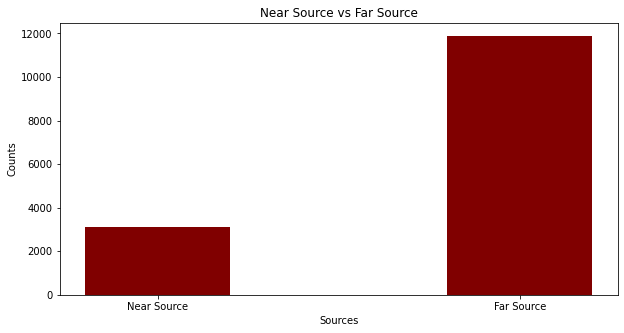

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# creating the dataset
data = {'Near Source': 3110, 'Far Source': 11886}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Sources")
plt.ylabel("Counts")
plt.title("Near Source vs Far Source")
plt.show()

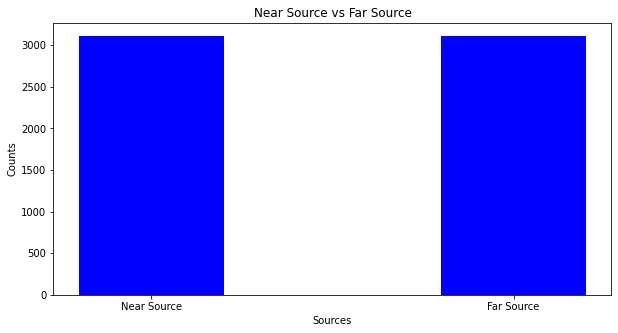

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# creating the dataset
data = {'Near Source': 3110, 'Far Source': 3110}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color ='blue',
        width = 0.4)
 
plt.xlabel("Sources")
plt.ylabel("Counts")
plt.title("Near Source vs Far Source")
plt.show()

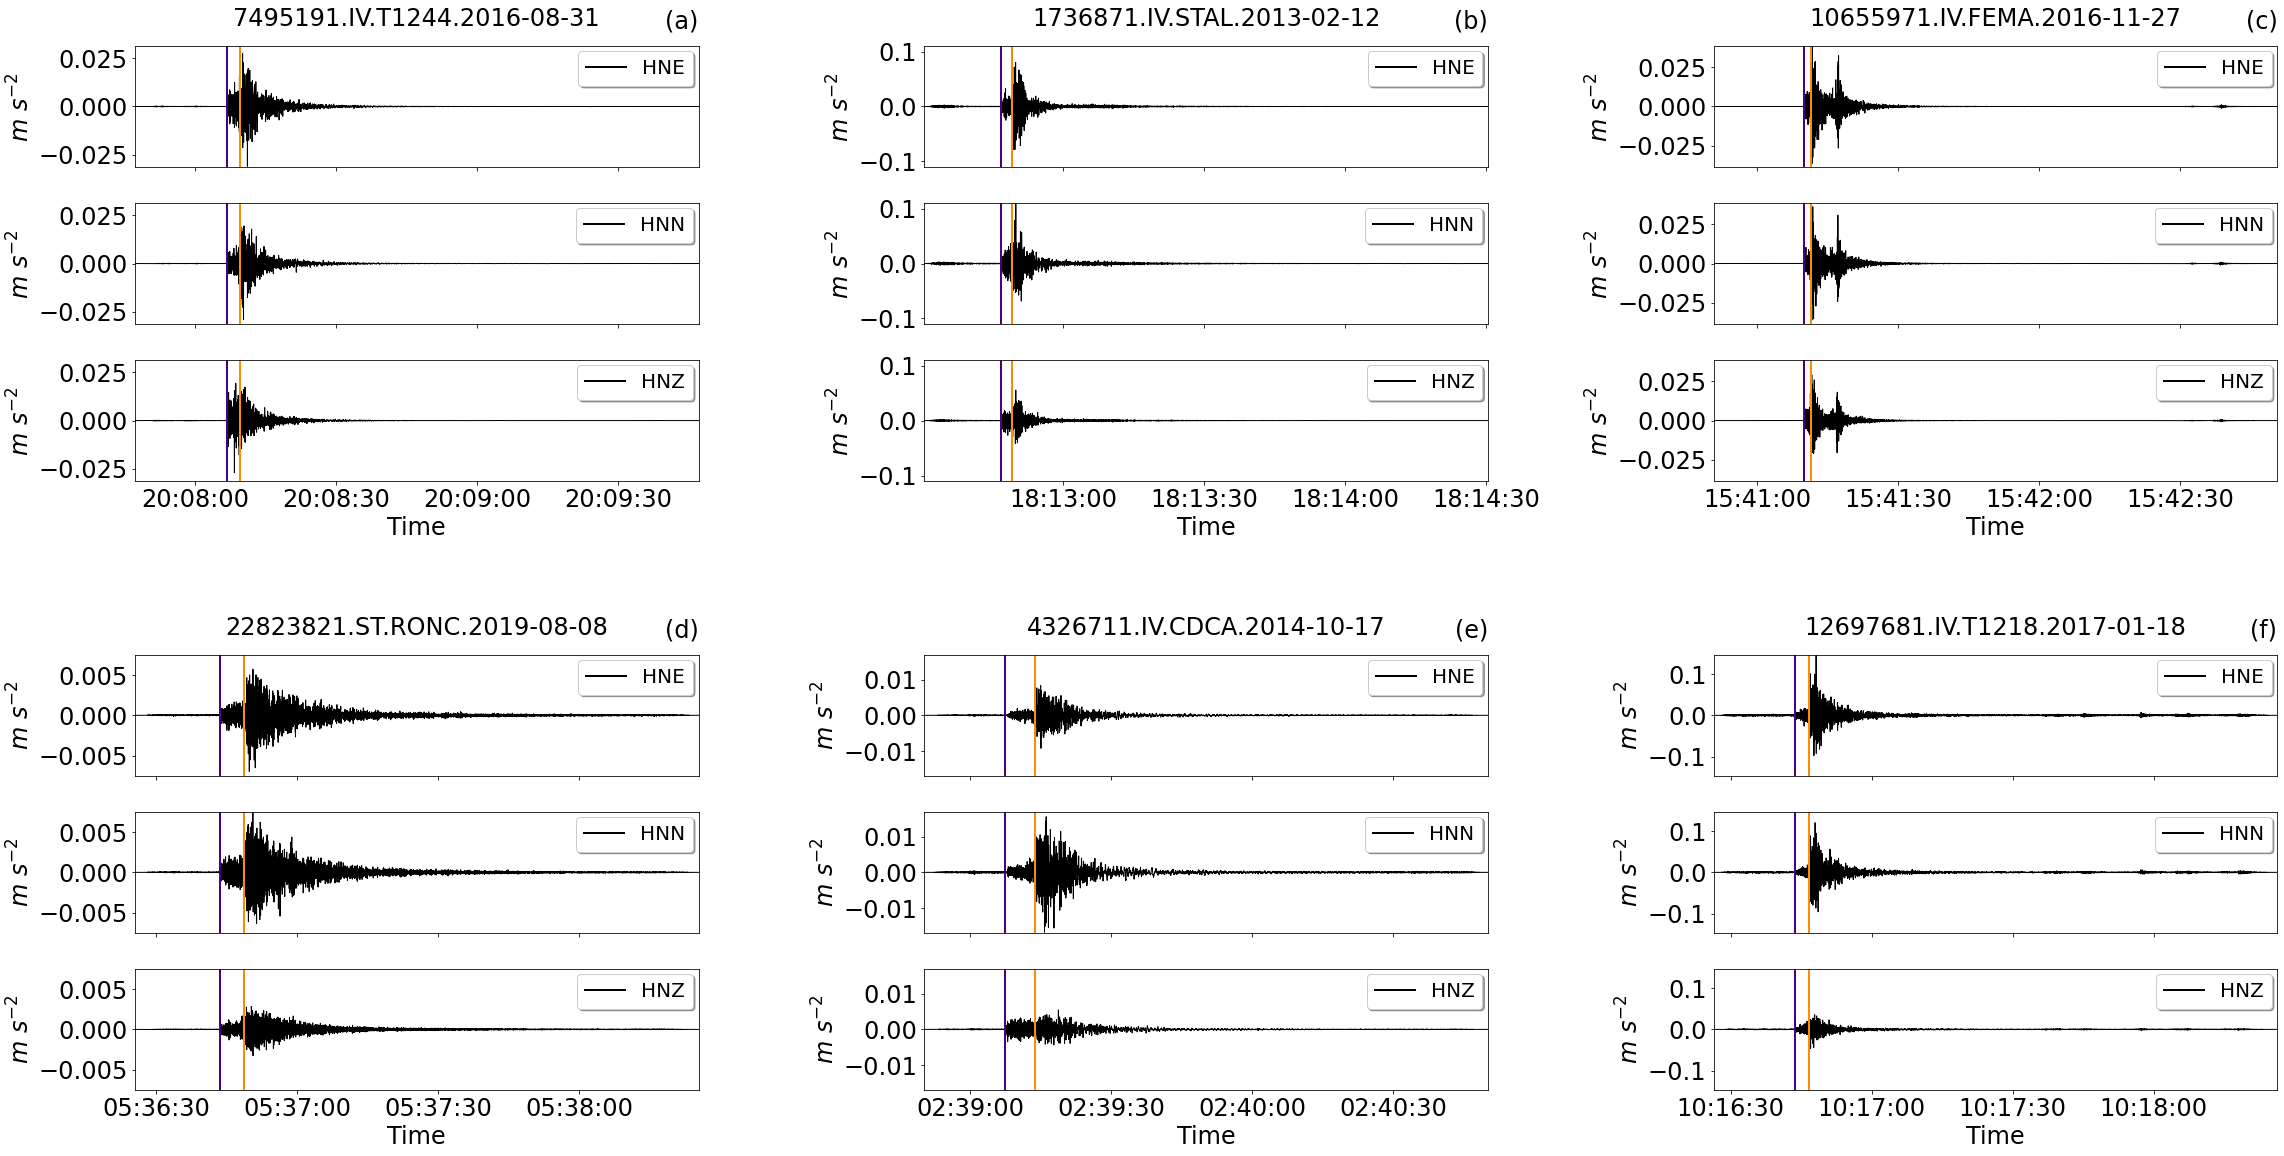

In [14]:
lines = chosen_lines
# Kind of unit
# units = len(lines)*["counts"]
units = ["$m~s^{-2}$","$m~s^{-2}$","$m~s^{-2}$","$m~s^{-2}$","$m~s^{-2}$","$m~s^{-2}$"]

# Do you want the traces filtered?
filt = False
freq_min=3.0
freq_max=20.0

nrow=int(len(lines)/plots_line)
ncol=plots_line

labs = alllabs[:(ncol*nrow)]

wftype='ev_gm'
df = events_metaData
h5 = gm_h5File

multiple_streams(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max)
gm_figname=os.path.join(FIGDIR, 'Near-source-vs-far-source-PGA.png')
plt.savefig(gm_figname,dpi=300)

# EXTRACT STREAMS

In [15]:
# SELECT STRONG MOTION CHANNELS
cha = 'HN'
strong_motion_data = events_metaData.loc[
    (events_metaData.source_magnitude >= 3) &
    (events_metaData.path_ep_distance_km <= 50) &
    (events_metaData['station_channels'] == cha)
]

TOTAL = strong_motion_data.shape[0]
TOTAL

14996

In [16]:
idxs = list(strong_motion_data.index)
print(len(idxs))

14996


In [17]:
wftype='ev_gm'
df = events_metaData
h5 = gm_h5File

filt = False
freq_min=3.0
freq_max=20.0

events_streams = {}
for idx in idxs:
    data = {}
    stream, row = build_stream(df,h5,idx,wftype, filt, freq_min, freq_max)
    data['stream'] = stream
    data['metadata'] = {
        'timeP': row['trace_P_arrival_time'],
        'timeS': row['trace_S_arrival_time'],
        'epi_dist': row['path_ep_distance_km'],
        'hyp_dist': row['path_hyp_distance_km'],
    }
    events_streams[row['trace_name']] = data
print(len(events_streams)) #14996

14996


In [18]:
import pickle
def save_streams(name, data):
    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(data, f)

def load_streams(name):
    with open(f'{name}.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    return loaded_dict

In [19]:
save_streams('train.all_ingv_events_streams', events_streams)

In [20]:
events_streams = load_streams('train.all_ingv_events_streams')

In [21]:
from obspy.core import Stream
import datetime
from obspy import UTCDateTime

ONE_SEC = 1
def extract_one_sec_of_pwave(pstart, stream):
    one_sec_pwave_stream = Stream()
    for tr in stream:
        dt = tr.stats.delta
        pstarttime = UTCDateTime(pstart)
        one_sec_pwave_stream += tr.slice(pstarttime, pstarttime + ONE_SEC - dt)
    return one_sec_pwave_stream


one_sec_pwave_events_streams = {}
filtered_one_sec_pwave_events_streams = {}
for event in events_streams:
    data = events_streams[event]
    stream = data['stream']
    pw_onset = data['metadata']['timeP']
    one_sec_data = extract_one_sec_of_pwave(pw_onset, stream)
    one_sec_data_copy = one_sec_data.copy()
    one_sec_pwave_events_streams[event] = one_sec_data
    one_sec_data_copy.detrend(type='linear')
    one_sec_data_copy.filter(type='bandpass', freqmin=3, freqmax=20)
    filtered_one_sec_pwave_events_streams[event] = one_sec_data_copy

save_streams('train.one_sec_ingv_pwave_events_streams', one_sec_pwave_events_streams)
save_streams('train.filtered_ingv_one_sec_pwave_events_streams', filtered_one_sec_pwave_events_streams)

In [22]:
import numpy as np
def create_ss_waveform_data(stream):
    matrix = np.array([tr.data for tr in stream])
    return np.sqrt(np.sum(np.square(matrix), axis=0))

In [23]:
geo_means = {}
for event in one_sec_pwave_events_streams:
    st = one_sec_pwave_events_streams[event]
    geo_mean = create_ss_waveform_data(st)
    geo_means[event] = geo_mean

save_streams('train.one_sec_ingv_geo_means', geo_means)

In [24]:
import numpy as np
from obspy.core import Stream
def create_absolute_stream(stream):
    abs_traces = []
    for tr in stream:
        abs_trace = tr.copy()
        abs_trace.data = np.abs(tr.data)
        abs_traces.append(abs_trace)
    return Stream(traces=abs_traces)

In [25]:
abs_one_sec_pwave_events_streams = {}
for event in one_sec_pwave_events_streams:
    st = one_sec_pwave_events_streams[event]
    one_sec_abs_pwave_stream = create_absolute_stream(st)
    abs_one_sec_pwave_events_streams[event] = one_sec_abs_pwave_stream

save_streams('train.abs_one_sec_ingv_pwave_events_streams', abs_one_sec_pwave_events_streams)

In [26]:
import numpy as np
from obspy.core import Stream
def create_cumabs_stream(abs_stream):
    cumabs_traces = []
    for tr in abs_stream:
        cumabs_trace = tr.copy()
        cumabs_trace.data = np.cumsum(tr.data)
        cumabs_traces.append(cumabs_trace)
    return Stream(traces=cumabs_traces)

In [27]:
cumabs_one_sec_pwave_events_streams = {}
for event in abs_one_sec_pwave_events_streams:
    st = abs_one_sec_pwave_events_streams[event]
    one_sec_cumabs_pwave_stream = create_cumabs_stream(st)
    cumabs_one_sec_pwave_events_streams[event] = one_sec_cumabs_pwave_stream

save_streams('train.cumabs_one_sec_ingv_pwave_events_streams', cumabs_one_sec_pwave_events_streams)

# ONE SEC DATA LOAD

In [28]:
# load onesec pwave data here, if not available
import pickle
def load_streams(name):
    with open(f'{name}.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    return loaded_dict

all_events_streams = load_streams('train.all_ingv_events_streams')
one_sec_pwave_events_streams = load_streams('train.one_sec_ingv_pwave_events_streams')
filtered_one_sec_pwave_events_streams = load_streams('train.filtered_ingv_one_sec_pwave_events_streams')
abs_one_sec_pwave_events_streams = load_streams('train.abs_one_sec_ingv_pwave_events_streams')
cumabs_one_sec_pwave_events_streams = load_streams('train.cumabs_one_sec_ingv_pwave_events_streams')
geo_means = load_streams('train.one_sec_ingv_geo_means')

In [29]:
def create_station_dict(station_name, normalize=False):
    all = all_events_streams[station_name].copy()
    one_sec_acc = one_sec_pwave_events_streams[station_name].copy()
    one_sec_filt = filtered_one_sec_pwave_events_streams[station_name].copy()
    one_sec_abs = abs_one_sec_pwave_events_streams[station_name].copy()
    one_sec_cumabs = cumabs_one_sec_pwave_events_streams[station_name].copy()

    one_sec_acc = one_sec_acc.normalize() if normalize else one_sec_acc
    one_sec_filt = one_sec_filt.normalize() if normalize else one_sec_filt
    one_sec_abs = one_sec_abs.normalize() if normalize else one_sec_abs
    one_sec_cumabs = one_sec_cumabs.normalize() if normalize else one_sec_cumabs

    return {
        'all_time_acc': all,
        'one_sec_acc': one_sec_acc,
        'one_sec_filt_acc': one_sec_filt,
        'one_sec_abs_acc': one_sec_abs,
        'one_sec_cumabs_acc': one_sec_cumabs,
    }

In [30]:
import os
import matplotlib.pyplot as plt

FIGDIR='./ingv_output'
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    figname=os.path.join(FIGDIR, fig_id)
    plt.savefig(figname, format=fig_extension, dpi=resolution)

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def plot_all_features(near, far, figname):
    figure, axis = plt.subplots(4, 3, figsize=(15,15))

    FEATURES = ['Acc', 'Filt', 'Abs', 'CumAbs']
    COMPONENTS = ['HNE', 'HNN', 'HNZ']
    FEATURES_DATA_MAP = {
        'Acc': 'one_sec_acc',
        'Filt': 'one_sec_filt_acc',
        'Abs': 'one_sec_abs_acc',
        'CumAbs': 'one_sec_cumabs_acc'
    }

    x = np.array([i for i in range(100)])
    for row, feature in enumerate(FEATURES):
        for col, comp in enumerate(COMPONENTS):
            near_stream = near[FEATURES_DATA_MAP[feature]]
            far_stream = far[FEATURES_DATA_MAP[feature]]
            for ntrace, ftrace in zip(near_stream, far_stream):
                nchannel, fchannel = ntrace.stats.channel, ftrace.stats.channel
                if nchannel == comp:
                    axis[row, col].plot(x, ntrace.data, color='b')
                if fchannel == comp:
                    axis[row, col].plot(x, ftrace.data, color='r')
            axis[row, col].set_title(f'{feature} {comp}')
    save_fig(figname)
    plt.show()


Saving figure normalized_all_ingv_feature_plot_with_obspy


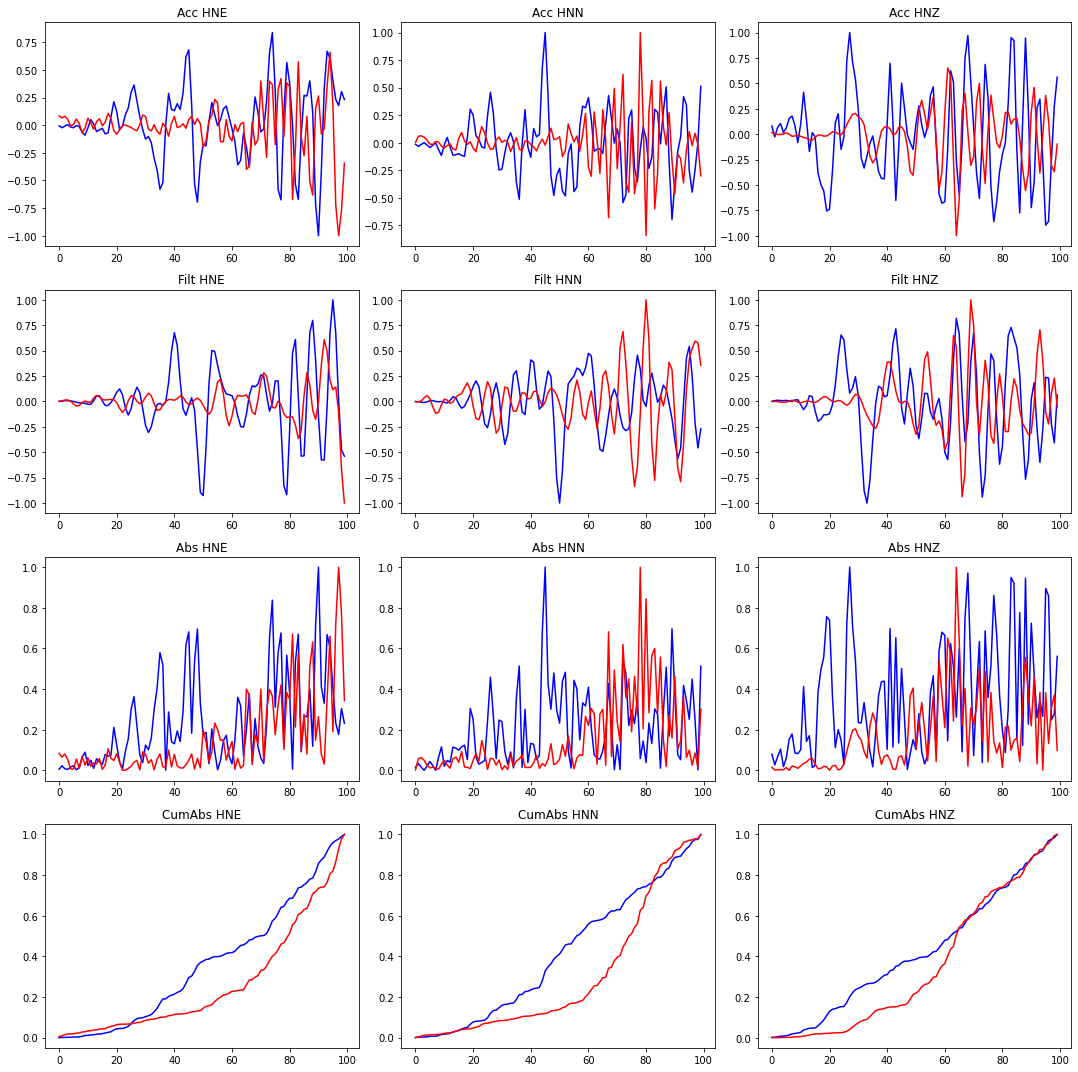

In [35]:
norm_near = create_station_dict('10655971.IV.FEMA..HN', True)
norm_far = create_station_dict('4326711.IV.CDCA..HN', True)
plot_all_features(norm_near, norm_far, "normalized_all_ingv_feature_plot_with_obspy")

Saving figure notnormalized_all_ingv_feature_plot_with_obspy


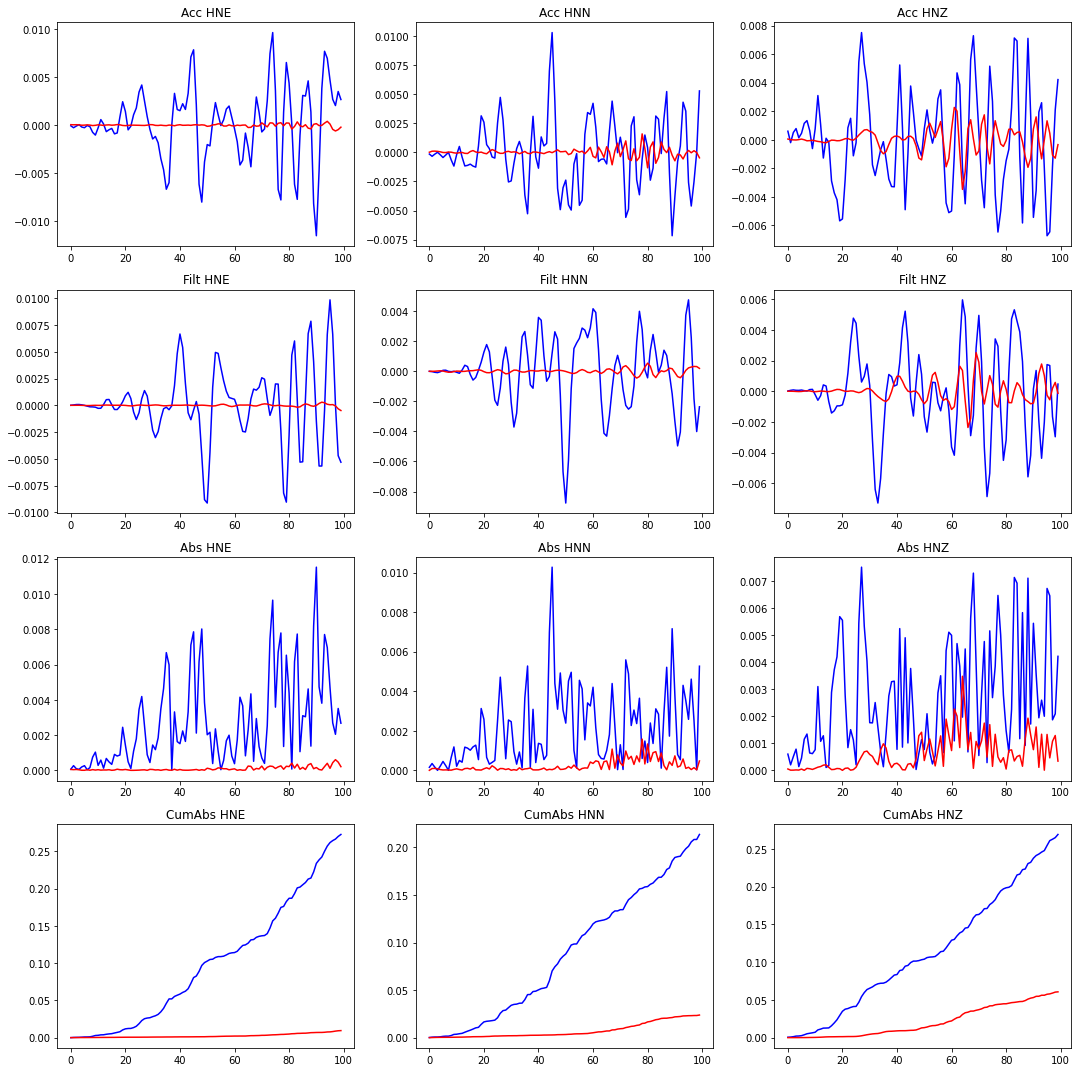

In [36]:
norm_near = create_station_dict('10655971.IV.FEMA..HN', False)
norm_far = create_station_dict('4326711.IV.CDCA..HN', False)
plot_all_features(norm_near, norm_far, "notnormalized_all_ingv_feature_plot_with_obspy")

# ML

In [37]:
from obspy.geodetics import gps2dist_azimuth

def get_input_matrix(station_name):
    """ return 13 x 100 matrix """

    data = create_station_dict(station_name, True)
    mega_features = [
        'one_sec_acc',
        'one_sec_filt_acc',
        'one_sec_abs_acc',
        'one_sec_cumabs_acc'
    ]

    input_matrix = []
    for mfeat in mega_features:
        stream = data[mfeat]
        for tr in stream:
            input_matrix.append(tr.data.tolist())

    # add geomean normalised waveform to feature
    geo_mean = geo_means[station_name]
    scaled_geo_mean = geo_mean / float(np.max(geo_mean))
    input_matrix.append(scaled_geo_mean.tolist())

    return input_matrix

def get_output_matrix(station_name, epi_dist):
    """ return vec of size 13 """
    #  NEAR SOURCE: 1
    #  FAR  SOURCE: 0

    data = create_station_dict(station_name, True)
    is_near_source = int(epi_dist < 17)
    return [is_near_source for _ in range(13)]

In [38]:
import pickle
def save_streams(name, data):
    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(data, f)

def load_streams(name):
    with open(f'{name}.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    return loaded_dict


X, y = [], []
near_source_count = 0
for station in one_sec_pwave_events_streams:
    epi_dist = all_events_streams[station]['metadata']['epi_dist']
    inp = get_input_matrix(station)
    outp = get_output_matrix(station, epi_dist)
    if outp[0] == 1: near_source_count += 1
    X.append(inp)
    y.append(outp)
data = {'X': X, 'y':y}
print(f'The total event is : {len(y)}') # 14996
print(f'The total near source event is : {near_source_count}') # 3110
print(f'The total far source event is : {len(y) - near_source_count}') #11886
save_streams('INGV_ML_DATA', data)

The total event is : 14996
The total near source event is : 3110
The total far source event is : 11886


In [39]:
import csv

with open('./INGV_ML_CSV_DATA.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=['X', 'y'])
    writer.writeheader()
    for Xi, yi in zip(X, y):
        writer.writerow({'X': str(Xi), 'y': yi[0]})

In [43]:
near = [
    '7495191.IV.T1244..HN',
    '1736871.IV.STAL..HN',
    '10655971.IV.FEMA..HN'
]
far = [
    '12697681.IV.T1218..HN',
    '4326711.IV.CDCA..HN',
    '22823821.ST.RONC..HN'
]
for n, f in zip(near, far):
    nmeta = all_events_streams[n]['metadata']
    fmeta = all_events_streams[f]['metadata']
    print(f'>>>>>>>>> {n}')
    print(f'METADAT {nmeta}')
    print(f'>>>>>>>>> {f}')
    print(f'METADAT {fmeta}')

>>>>>>>>> 7495191.IV.T1244..HN
METADAT {'timeP': '2016-08-31T20:08:06.80Z', 'timeS': '2016-08-31T20:08:09.60Z', 'epi_dist': 15.39, 'hyp_dist': 18.086}
>>>>>>>>> 12697681.IV.T1218..HN
METADAT {'timeP': '2017-01-18T10:16:43.75Z', 'timeS': '2017-01-18T10:16:46.60Z', 'epi_dist': 19.317, 'hyp_dist': 20.986}
>>>>>>>>> 1736871.IV.STAL..HN
METADAT {'timeP': '2013-02-12T18:12:46.67Z', 'timeS': '2013-02-12T18:12:49.13Z', 'epi_dist': 10.85, 'hyp_dist': 15.099}
>>>>>>>>> 4326711.IV.CDCA..HN
METADAT {'timeP': '2014-10-17T02:39:07.39Z', 'timeS': '2014-10-17T02:39:13.79Z', 'epi_dist': 41.752, 'hyp_dist': 43.789}
>>>>>>>>> 10655971.IV.FEMA..HN
METADAT {'timeP': '2016-11-27T15:41:09.93Z', 'timeS': '2016-11-27T15:41:11.36Z', 'epi_dist': 5.44, 'hyp_dist': 9.674}
>>>>>>>>> 22823821.ST.RONC..HN
METADAT {'timeP': '2019-08-08T05:36:43.53Z', 'timeS': '2019-08-08T05:36:48.70Z', 'epi_dist': 41.756, 'hyp_dist': 43.105}
